In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

%matplotlib inline
import matplotlib.pyplot as plt

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

from PIL import Image
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import matplotlib.cm as cm
from matplotlib.pyplot import subplots

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib

import yaml

zsh:1: command not found: nvcc
torch:  2.0 ; cuda:  2.0.0.dev20230228
detectron2: 0.6


In [2]:
ROOT_DIR = "/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd"

MODEL_DATA_DIR = os.path.join(ROOT_DIR, "processed")

MODEL_TRAIN_DATA_DIR = os.path.join(MODEL_DATA_DIR,"train")
MODEL_VAL_DATA_DIR = os.path.join(MODEL_DATA_DIR,"val")
MODEL_TEST_DATA_DIR = os.path.join(MODEL_DATA_DIR,"test")


# Annotation Dataset

In [3]:
def tuple_to_unique_number(charge_state):
    prime_numbers = [3, 5]  # List of prime numbers, should be equal to number of charge states
    unique_number = sum(element * prime_numbers[index] for index, element in enumerate(charge_state))
    return int(unique_number)

max_charge = 2
all_charge_states = [(i,j) for i in range(max_charge + 1) for j in range(max_charge+1) ]
all_charge_states_values = [tuple_to_unique_number(charge_state) for charge_state in all_charge_states]

charge_state_dict = dict(zip(all_charge_states, all_charge_states_values))
charge_value_dict = dict(zip(all_charge_states_values, all_charge_states))

for test in all_charge_states:
    unique_number = tuple_to_unique_number(test)
    print("{} => {}".format(test, unique_number))

# charge states that matter
min_charge = 0
max_charge = 2
spin_qubit_charge_states = [(i,j) for i in range(min_charge,max_charge + 1) for j in range(min_charge,max_charge + 1)]
classes = [tuple_to_unique_number(x) for x in spin_qubit_charge_states]
print(spin_qubit_charge_states, classes)

(0, 0) => 0
(0, 1) => 5
(0, 2) => 10
(1, 0) => 3
(1, 1) => 8
(1, 2) => 13
(2, 0) => 6
(2, 1) => 11
(2, 2) => 16
[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)] [0, 5, 10, 3, 8, 13, 6, 11, 16]


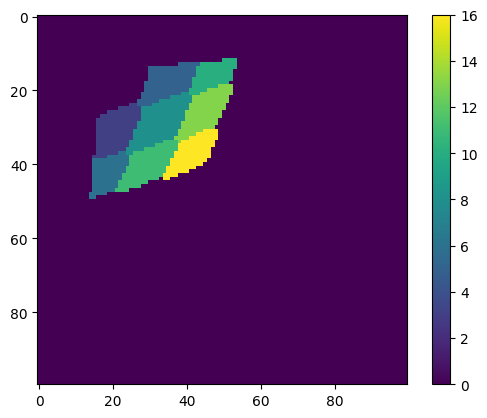

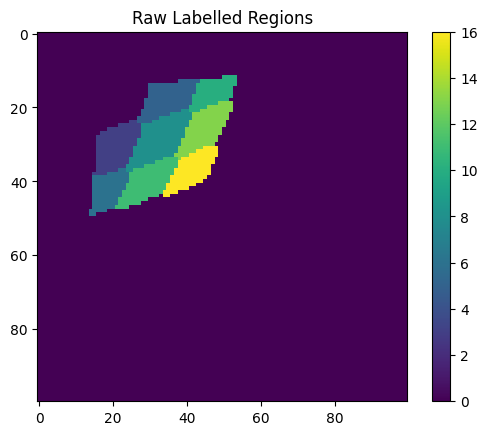

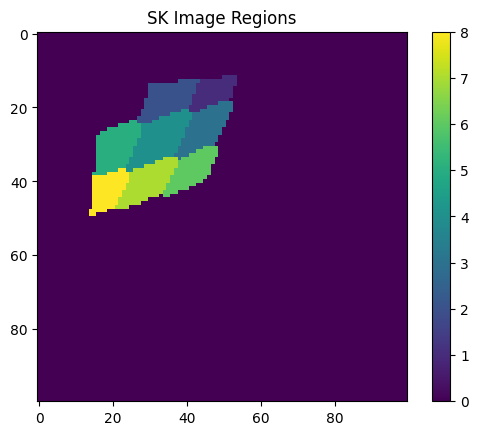

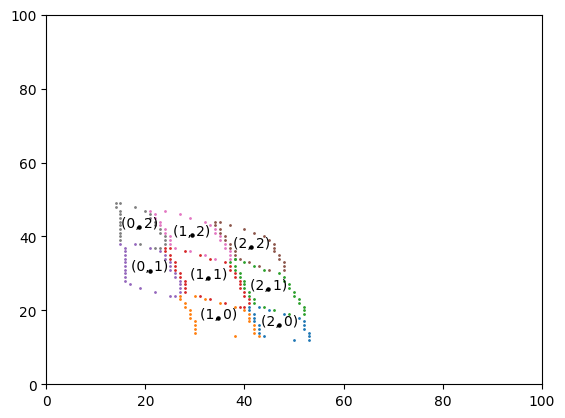

In [4]:
import skimage as sk
# raw
# file_path = "/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/raw/20200714-140115023515_cr1279.npy"
file_path = "/Users/andrijapaurevic/Desktop/data_qflow_lite/20171118-131209334790.npy"
# file_path = "/Users/andrijapaurevic/Desktop/data_qflow_lite/20171118-123723470541.npy"
# file_path = "/Users/andrijapaurevic/Documents/uwaterloo/research/QuantumDotControl/autotuning/data/csd/raw/20171118-130123656336.npy"
# file_path = "/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/raw/20200711-161944699948_cr145.npy"
# file_path = "/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/raw/20200714-172019089587_cr1444.npy"

# Loads, *.npy file, extracts CSD
qflow_data = np.load(file_path, allow_pickle=True).item()

voltage_P1_key = "x" if "d_" in file_path else "V_P1_vec"
voltage_P2_key = "y" if "d_" in file_path else "V_P2_vec"
VP1 = qflow_data[voltage_P1_key]
VP2 = qflow_data[voltage_P2_key]
N = len(qflow_data[voltage_P1_key])
M = len(qflow_data[voltage_P2_key])

# try:
csd_qd_states = np.array([
    tuple_to_unique_number(data['charge'])  for data in qflow_data['output']
]).reshape((N,M) if N > M else (M,N))

csd_qd_regimes = np.array([
    data['state']  for data in qflow_data['output']
]).reshape((N,M) if N > M else (M,N))

DD_mask = (csd_qd_regimes == 2)

important_class_mask = np.zeros(csd_qd_states.shape, dtype=bool)

for x in classes:
    # print(x, charge_value_dict[x])
    important_class_mask |= (csd_qd_states == x)

csd_qd_states = csd_qd_states * DD_mask
csd_qd_states = csd_qd_states * important_class_mask

plt.imshow(csd_qd_states)
plt.colorbar()
plt.show()

actual_charge_state_image = np.array([data['charge'] for data in qflow_data['output']], dtype=object).reshape((N,M) if N > M else (M,N))

background = -1
    # correction = 1

# except:
#     print("Can only use 2017 ones")

csd_qd_labelled_regions = sk.measure.label(csd_qd_states, connectivity=1)

csd_qd_regions = sk.measure.regionprops(csd_qd_labelled_regions)

num_of_predicted_regions = len(csd_qd_regions)

plt.imshow(csd_qd_states)
plt.title("Raw Labelled Regions")
plt.colorbar()
plt.show()

plt.imshow(csd_qd_labelled_regions)
plt.title("SK Image Regions")
plt.colorbar()
plt.show()

csd_object_list = []
regions_list = []

fig, ax = plt.subplots()
patches = []

centroid_list = []

for index in range(len(csd_qd_regions)):
    region_info = {}

    region_coords = csd_qd_regions[index].coords

    # Get boundaries of coordiantes
    temp = {}
    for row in region_coords:
        key = row[0]
        value = row[1]
        if key not in temp:
            temp[key] = [value, value]  # Initialize with the current value
        else:
            temp[key][0] = min(temp[key][0], value)  # Update minimum value
            temp[key][1] = max(temp[key][1], value)  # Update maximum value
    region_coords = np.array([[key, minmax[0]] for key, minmax in temp.items()] + [[key, minmax[1]] for key, minmax in temp.items()])

    y,x = region_coords.T

    px = x.tolist()
    py = y.tolist()

    def flip_coordinates_horizontal_axis(x_coordinates, y_coordinates, axis):
        flipped_x_coordinates = []
        flipped_y_coordinates = []
        
        for x, y in zip(x_coordinates, y_coordinates):
            distance = (axis - y)
            y_flipped = axis + distance
            flipped_x_coordinates.append(x)
            flipped_y_coordinates.append(y_flipped)
        
        return flipped_x_coordinates, flipped_y_coordinates

    def find_polygon_centroid(coordinates):

        n = len(coordinates)
        
        # Calculate the signed area of the polygon
        signed_area = 0
        for i in range(n):
            x_i, y_i = coordinates[i]
            x_j, y_j = coordinates[(i + 1) % n]
            signed_area += (x_i * y_j - x_j * y_i)
        signed_area *= 0.5
        
        # Calculate the coordinates of the centroid
        centroid_x = 0
        centroid_y = 0
        for i in range(n):
            x_i, y_i = coordinates[i]
            x_j, y_j = coordinates[(i + 1) % n]
            factor = x_i * y_j - x_j * y_i
            centroid_x += (x_i + x_j) * factor
            centroid_y += (y_i + y_j) * factor
        centroid_x /= (6 * signed_area)
        centroid_y /= (6 * signed_area)
        
        return centroid_x, centroid_y

    def organize_array_clockwise(arr):
            
        # Calculate the centroid of the points
        centroid = np.mean(arr, axis=0)

        # Calculate the angle of each point with respect to the centroid
        angles = np.arctan2(arr[:, 1] - centroid[1], arr[:, 0] - centroid[0])

        # Sort the points based on the angles in clockwise order
        indices = np.argsort(angles)
        sorted_arr = arr[indices]

        return sorted_arr      

    poly = [(x, y) for x, y in zip(px, py)]
    poly = np.array([p for x in poly for p in x]).reshape(-1,2)
    
    poly_clockwise = organize_array_clockwise(poly)
    x0, y0 = find_polygon_centroid(poly_clockwise)
    x0_, y0_ = flip_coordinates_horizontal_axis([x0], [y0], axis=csd_qd_states.shape[0]/2)
    x0_, y0_ = flip_coordinates_horizontal_axis(y0_, x0_, axis=csd_qd_states.shape[1]/2)
    x0_val, y0_val = x0_[0], y0_[0]


    patches.append(matplotlib.patches.Polygon(poly_clockwise))
    if (not(np.isnan(x0)) and not(np.isnan(y0))):
        
        charge_state = actual_charge_state_image[int(x0), int(y0)] 
        # if len(charge_state) == 1:
            # charge_state += (0,)
        # print(int(x0), int(y0), charge_state)
        centroid_list.append([x0, y0]) 
        plt.annotate(f"{charge_state}", (x0,y0), textcoords="offset points", xytext=(0,0), ha='center')
    plt.scatter([x0],[y0],c='black', s=5)

    plt.scatter(px,py, s=1)
    
plt.xlim(0,N)
plt.ylim(0,M)
plt.show()

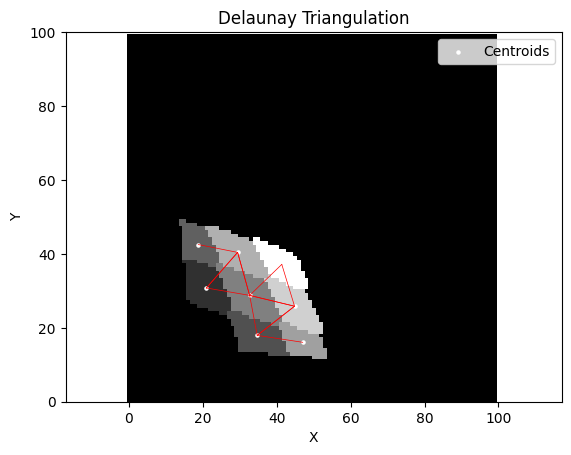

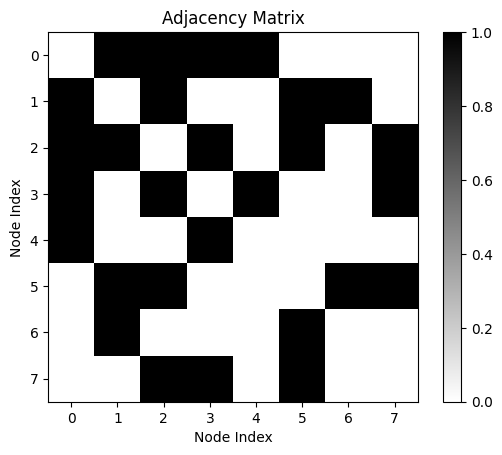

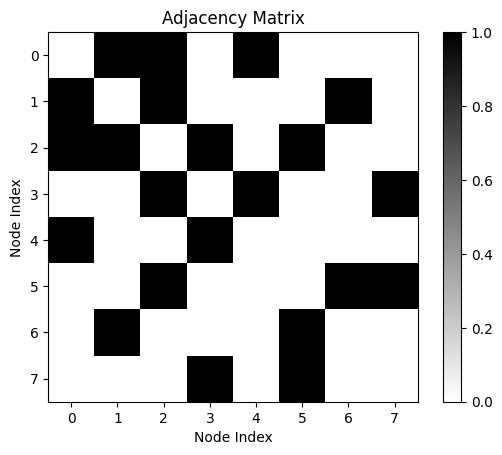

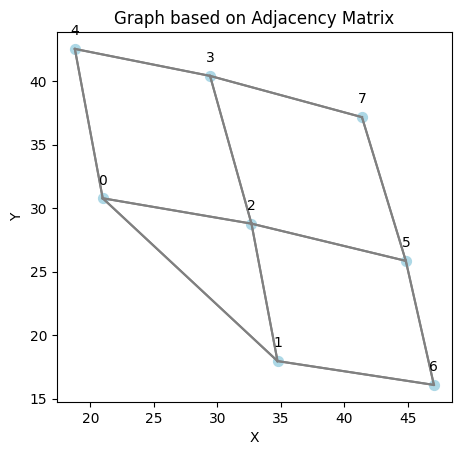

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# Assuming you have the 'points' array with the coordinates of the points
points = np.array(centroid_list)


# Target point
target_point = np.array([20,20])

# Custom distance calculation function
def distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

# Calculate distances from the target point for each coordinate
distances = np.array([distance(coord, target_point) for coord in points])

# Sort the coordinates based on distances
sorted_indices = np.argsort(distances)

# Sorted coordinates
points = points[sorted_indices]

# Perform Delaunay triangulation
tri = Delaunay(points)

# Get the simplices of the triangular mesh
triangles = tri.simplices

# Create adjacency matrix
adjacency_matrix = np.zeros((len(points), len(points)))
for triangle in triangles:
    adjacency_matrix[triangle[0], triangle[1]] = 1
    adjacency_matrix[triangle[1], triangle[0]] = 1
    adjacency_matrix[triangle[0], triangle[2]] = 1
    adjacency_matrix[triangle[2], triangle[0]] = 1
    adjacency_matrix[triangle[1], triangle[2]] = 1
    adjacency_matrix[triangle[2], triangle[1]] = 1

plt.imshow(csd_qd_states, cmap='gray')

# Plot the points
plt.scatter(points[:, 0], points[:, 1], c='white', label='Centroids', s=5)

# Plot the Delaunay triangles with color based on distance
for i, triangle in enumerate(triangles):

    x = points[triangle, 0]
    y = points[triangle, 1]
    plt.plot(points[triangle, 0], points[triangle, 1], 'r-', linewidth=0.5)

# Set axis labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Delaunay Triangulation')

# Set aspect ratio to equal and show the plot
plt.axis('equal')
plt.xlim([0, N])
plt.ylim([0, M])
plt.legend()
plt.show()

# Plot the adjacency matrix
plt.imshow(adjacency_matrix, cmap='binary')
plt.title('Adjacency Matrix')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.colorbar()
plt.show()


# Get the number of nodes
num_nodes = adjacency_matrix.shape[0]

filtered_adj_matrix = np.zeros((num_nodes, num_nodes))
for i in range(num_nodes):
    for j in range(num_nodes):
        if adjacency_matrix[i,j] == 1:
            
            coord1 = points[i]
            x0, y0 = coord1
            charge_state_1 = actual_charge_state_image[int(x0), int(y0)] 

            coord2 = points[j]
            x0, y0 = coord2
            charge_state_2 = actual_charge_state_image[int(x0), int(y0)] 

            if len(charge_state_1) == 1 and len(charge_state_2) == 1:
                charge_state_diff = [charge_state_1[0] - charge_state_2[0]]
                if -1 in charge_state_diff or 1 in charge_state_diff:
                    filtered_adj_matrix[i,j] = 1

            elif len(charge_state_1) == 2 and len(charge_state_2) == 2: 

                total_charge_1 = charge_state_1[0] + charge_state_1[1]

            
                # if len(charge_state_2) == 1:
                #     charge_state_2 += (0,)

                total_charge_2 = charge_state_2[0] + charge_state_2[1]
                
                charge_state_diff = tuple((charge_state_1[0] - charge_state_2[0], charge_state_1[1] - charge_state_2[1]))

                if i == 0 and j == 5:
                    print(charge_state_1, charge_state_2)
                if 0 in charge_state_diff and (1 in charge_state_diff or -1 in charge_state_diff):
                    filtered_adj_matrix[i,j] = 1
                if (1 in charge_state_diff and -1 in charge_state_diff) and total_charge_1 == total_charge_2:
                    filtered_adj_matrix[i,j] = 1
            # if charge
            #     if charge_state_1 + (0,) == charge_state_2:
            #         filtered_adj_matrix[i,j] = 1

adjacency_matrix = filtered_adj_matrix
# adjacency_matrix[:,:] =0 
# for i in range(num_nodes):
#     adjacency_matrix[i, (i+1) % num_nodes] = 1

# adjacency_matrix[:,:] =0 
# adjacency_matrix[0,2] =1 
# adjacency_matrix[1,2] =1 
# adjacency_matrix[1,7] =1 
# adjacency_matrix[7,18] =1 
# adjacency_matrix[18,15] =1 
# adjacency_matrix[15,4] =1 
# adjacency_matrix[4,2] =1 
# adjacency_matrix[2,0] =1 
# adjacency_matrix[0,3] =1 
# adjacency_matrix[7,4] =1 
# adjacency_matrix[4,8] =1 
# adjacency_matrix[15,12] =1 
# adjacency_matrix[12,8] =1 
# adjacency_matrix[8,5] =1 
# adjacency_matrix[2,5] =1 
# adjacency_matrix[0,6] =1 
# adjacency_matrix[3,9] =1 
# adjacency_matrix[5,6] =1 
# adjacency_matrix[6,9] =1 
# adjacency_matrix[6,16] =1 
# adjacency_matrix[16,19] =1 
# adjacency_matrix[9,19] =1 
# adjacency_matrix[5,14] =1
# adjacency_matrix[14,16] =1  
# adjacency_matrix[14,20] =1 
# adjacency_matrix[13,14] =1 
# adjacency_matrix[8,11] =1 
# adjacency_matrix[8,10] =1 
# adjacency_matrix[10,17] =1 
# adjacency_matrix[17,21] =1 
# adjacency_matrix[21,22] =1 
# adjacency_matrix[22,23] =1 
# Plot the adjacency matrix
plt.imshow(adjacency_matrix, cmap='binary')
plt.title('Adjacency Matrix')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.colorbar()
plt.show()

# 12, 17, 20, 23

# Plot the graph
fig, ax = plt.subplots()
# ax.imshow(csd_qd_states, cmap='gray')

ax.set_aspect('equal')

# Draw nodes
ax.scatter(points[:, 0], points[:, 1], c='lightblue', s=50)
# Add text annotations for each point
for i, point in enumerate(points):
    ax.annotate(str(i), (point[0], point[1]), textcoords="offset points",
                xytext=(0, 10), ha='center')
# Draw edges
for i in range(num_nodes):
    for j in range(num_nodes):
        if adjacency_matrix[i, j] == 1:

            ax.plot([points[i, 0], points[j, 0]],
                    [points[i, 1], points[j, 1]], color='gray')
            label = f"{i}, {j}"
            mid_x = (points[i, 0] + points[j, 0]) / 2
            mid_y = (points[i, 1] + points[j, 1]) / 2
            # ax.text(mid_x, mid_y, label, ha='center', va='center')

# Set axis labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graph based on Adjacency Matrix')

# Show the plot
plt.show()

# Virtual Gating

In [6]:
def find_missing_vertex(v0, v1, v2):
    # v0 and v2 are opposites
    v3_x = (v0[0] + v2[0]) - v1[0]
    v3_y = (v0[1] + v2[1]) - v1[1]

    return np.array([v3_x, v3_y])

def calculate_capacitance_matrix(P, P_updown, P_leftright):
    # P is point you want to calculate virtual gate matrix at

    dVP1 = P_updown[0] - P[0]
    dVP2 = P_leftright[1] - P[1]
    dVP1C = P[0] - P_leftright[0]
    dVP2C = P[1] - P_updown[1]

    CP1D1 = dVP2 / (dVP1 * dVP2 - dVP1C * dVP2C)
    CP2D2 = dVP1 / (dVP1 * dVP2 - dVP1C * dVP2C)

    CP1D2 = dVP2C / (dVP1 * dVP2 - dVP1C * dVP2C)
    CP2D1 = dVP1C / (dVP1 * dVP2 - dVP1C * dVP2C)
    
    return np.array([[1, (CP1D2/CP2D2)],[(CP2D1/CP1D1),1]])


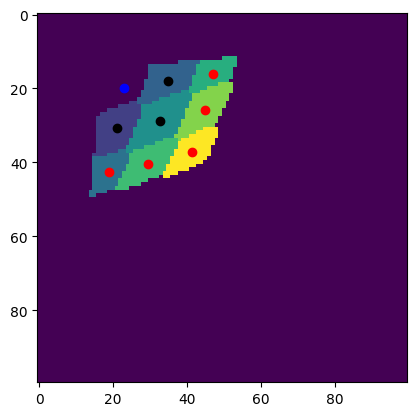

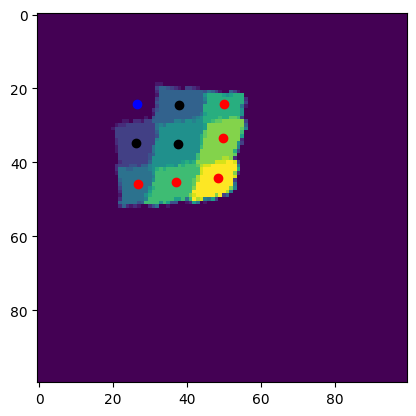

In [7]:
dV = VP1[1] - VP2[0]
P01 = points[0] 
P10 = points[1] 
P11 = points[2] 

P00 = find_missing_vertex(P01, P11, P10)
# np.append(points,P00)

plt.scatter(P01[0], P01[1],c='k')
plt.scatter(P10[0], P10[1],c='k')
plt.scatter(P11[0], P11[1],c='k')
plt.scatter(P00[0], P00[1],c='b')
plt.scatter(points[3:,0], points[3:,1], c='r')

from scipy.stats import linregress

C = calculate_capacitance_matrix(P11, P01, P10)

m01_11, b01_11, _ = linregress(P01, P11)[:3]
m10_11, b10_11, _ = linregress(P10, P11)[:3]
real_x = VP1 
real_y = VP2
dx = (real_x[1]-real_x[0])/2.
dy = (real_y[1]-real_y[0])/2.
extent = [real_x[0]-dx, real_x[-1]+dx, real_y[0]-dy, real_y[-1]+dy]
plt.imshow(csd_qd_states)
plt.show()

rows,cols = csd_qd_states.astype(np.uint8).shape
# apply affine transformation on the input image
image = cv2.warpAffine(csd_qd_states.astype(np.uint8),np.c_[C, [0,0]],(cols,rows))

P01 = np.matmul(C,P01)
P10 = np.matmul(C,P10)
P11 = np.matmul(C,P11)
P00 = np.matmul(C,P00)
points_new = np.dot(points, C)
plt.scatter(P01[0], P01[1],c='k')
plt.scatter(P10[0], P10[1],c='k')
plt.scatter(P11[0], P11[1],c='k')
plt.scatter(P00[0], P00[1],c='b')
plt.scatter(points_new[3:,0], points_new[3:,1], c='r')

plt.imshow(image)
plt.show()


In [8]:
# organizes double dot centroids into matrix allowing easy charge tuning
def create_points_matrix(points):
    points_to_search = points 
    points_final = []
    while len(points_to_search) > 0:

        top_left = sorted(points_to_search, key=lambda p: p[0] + p[1])[0]
        top_right = sorted(points_to_search, key=lambda p: p[0] - p[1])[-1]

        top_left = np.array([top_left[0], top_left[1],0])
        top_right = np.array([top_right[0], top_right[1],0])

        row_points = []
        remaining_points = []
        for point in points_to_search:
            p = np.array([point[0], point[1], 0])
            threshold = 5 # should be like E charging / 2
            dist = np.linalg.norm(np.cross(np.subtract(p, top_left), np.subtract(top_right,top_left))) / np.linalg.norm(top_right) # length of perpendicular distance from point to line spanning topleft to topright
            if dist < threshold / 2:
                row_points.append(point)
            else:
                remaining_points.append(point)

        points_final.append(sorted(row_points, key = lambda h : h[0]))
        points_to_search = remaining_points

    return points_final

# original_centroids = points
# points_matrix = create_points_matrix(points_new)

# start_charge_state = (0,0)
# desired_charge_state = (2,2)
# charge_state_path =  [(start_charge_state[0], y) for y in range(start_charge_state[1], desired_charge_state[0]+1)] + [(x, desired_charge_state[0]) for x in range(start_charge_state[0] + 1,desired_charge_state[1]+1)]

# virtual_coordinate_path = [points_matrix[point[0]][point[1]] for point in charge_state_path]
# actual_coordinate_path = [np.dot(virtual_point, np.linalg.inv(C)) for virtual_point in virtual_coordinate_path]

# # print(charge_state_path, virtual_coordinate_path, actual_coordinate_path)

# for point in charge_state_path:
#     centroid = points_matrix[point[0]][point[1]]
#     plt.scatter(centroid[0],centroid[1], c='w')

# plt.imshow(image)
# plt.show()

In [9]:
from collections import deque

def find_valid_path(dictionary, start, stop):
    if start == stop:
        return [start]

    tuple_str_list = list(dictionary.keys())
    key_as_tuple_list = [tup for tup in tuple_str_list]

    visited = set()
    queue = deque()
    queue.append([start])

    while queue:
        path = queue.popleft()
        current_position = path[-1]

        if current_position == stop:
            return path

        if current_position not in visited:
            visited.add(current_position)

            # Get the valid neighbors (add or remove 1 from either value)
            neighbors = []
            for neighbor in [(current_position[0] + 1, current_position[1]),
                             (current_position[0] - 1, current_position[1]),
                             (current_position[0], current_position[1] + 1),
                             (current_position[0], current_position[1] - 1)]:
         
                if neighbor in key_as_tuple_list:
                    neighbors.append(neighbor)

            for neighbor in neighbors:
                new_path = list(path)
                new_path.append(neighbor)
                queue.append(new_path)

    return None

# Algorithm Applied to Inference

{'learning_rate': 0.0002, 'augments_per_sim_img': 5, 'augments_per_exp_img': 100, 'num_epochs': 7000, 'batch_num': 10, 'dataset_size': 1001, 'train_val_split': 0.8, 'batch_size_per_img': 128}
[05/23 09:52:17 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/models/charge_state/model_sept_13_charge_state.pth ...


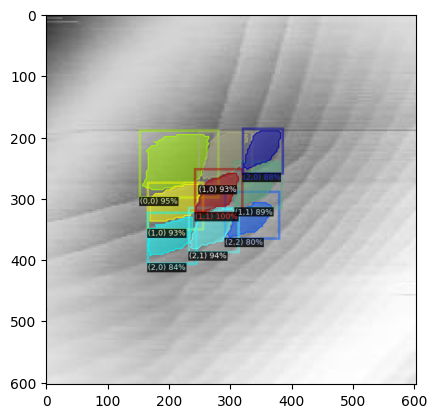

01 is not defined.


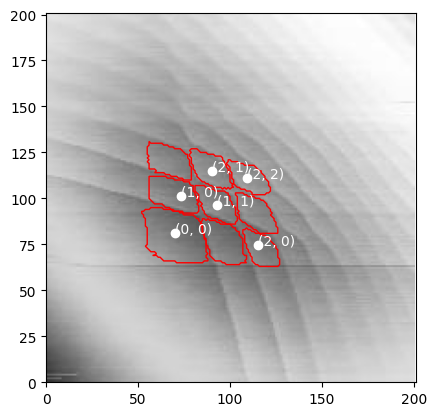

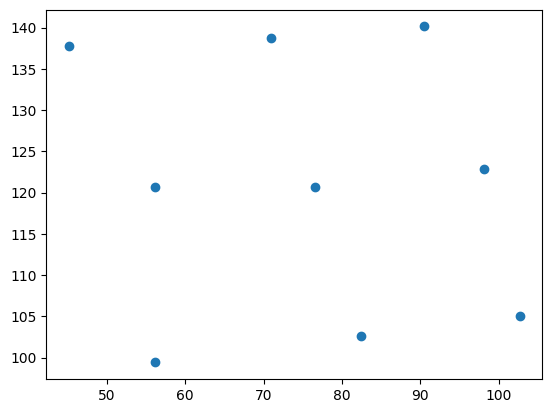

3 

3 

3 

[(0, 0), (0, 1), (0, 2), (1, 2), (2, 2)]
[(0, 0), (1, 0), (2, 0), (2, 1), (2, 2)]
[[ 0.95704956 -0.25221843]
 [ 0.16297657  0.95704956]]
[56.13281075 99.40812039]
[69.923077 80.980769] (0, 0)
[ 73.387097 101.322581] (1, 0)
[ 65.638889 120.5     ] (2, 0)
[ 90.479167 114.916667] (2, 1)
[109.472222 111.277778] (2, 2)


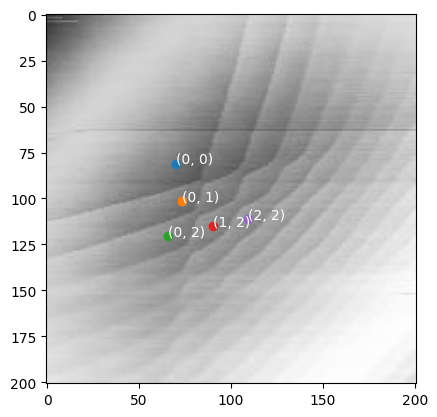

In [11]:
# Load trained model path
model_path = "/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/models/charge_state/model_sept_13_charge_state.pth" # path to the model we just trained
model_name = 'charge_state'

config_path = "../../coarse_tuning/src/config.yaml"

processor = 'cpu'

with open(config_path, 'r') as config_yaml:
            model_yaml = yaml.load(config_yaml, Loader=yaml.FullLoader)
            model_config = model_yaml[model_name]
            model_info = model_config['info']
            model_hyperparams = model_config['hyperparameters']

            model_device = model_yaml['device']

ROOT_DIR = "../../../autotuning/data/csd"

MODEL_DATA_DIR = os.path.join(ROOT_DIR, "processed")

MODEL_TRAIN_DATA_DIR = os.path.join(MODEL_DATA_DIR,"train")
MODEL_VAL_DATA_DIR = os.path.join(MODEL_DATA_DIR,"val")
MODEL_TEST_DATA_DIR = os.path.join(MODEL_DATA_DIR,"test")

from detectron2.engine import DefaultTrainer

print(model_hyperparams)

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("csd_train",)
cfg.DATASETS.TEST = ()

cfg.MODEL.DEVICE = processor 
cfg.DATALOADER.NUM_WORKERS = model_device[processor]['num_workers']

cfg.SOLVER.IMS_PER_BATCH = model_hyperparams['batch_num']
cfg.SOLVER.BASE_LR = model_hyperparams['learning_rate']
cfg.SOLVER.MAX_ITER = model_hyperparams['num_epochs']
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = model_hyperparams['batch_size_per_img']
cfg.MODEL.ROI_HEADS.NUM_CLASSES = model_info['num_of_classes'] 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = model_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8 # set a custom testing threshold
predictor = DefaultPredictor(cfg)

def get_csd_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        record["file_name"] = os.path.join(img_dir, v["filename"])
        record["image_id"] = idx

        annos = v["regions"]

        objs = []

        if type(annos) == list: # custom JSONs are in list format need to make them the same
             annos = dict(enumerate(annos))

        for _, anno in annos.items():

            regions = anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]

            # if len(px) <= 10 or len(py) <= 10:
            #         # print("Ignoring polygon from ", v["filename"], "because a polygon was too small for detectron2.")
            #         continue
            
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            try: 
                category_dict = {"ND": 0, "LD": 1, "CD": 2, "RD": 3, "DD": 4}
                category_id = category_dict[regions["label"]]

            except KeyError:
                # diff model
                category_dict = {0: 0, 5: 1, 10: 2, 3: 3, 8: 4, 13: 5, 6:6, 11:7, 16:8} # converts the unique charge state number to an ID.
                class_dict = {"(0,0)": 0, "(0,1)": 5, "(0,2)": 10, "(1,0)": 3, "(1,1)": 8, "(1,2)": 13, "(2,0)": 6, "(2,1)": 11, "(2,2)": 16}
                try: 
                    category_id = category_dict[regions["label"]]
                except KeyError:
                    category_id = category_dict[class_dict[regions['label']]]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": category_id,
            }

            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts

DatasetCatalog.clear()
MetadataCatalog.clear()

for d in ["train", "val"]:
    DatasetCatalog.register("csd_" + d, lambda d=d: get_csd_dicts(os.path.join(MODEL_DATA_DIR,d)))
    MetadataCatalog.get("csd_" + d).set(thing_classes=list(model_info['class_dict'].keys()))

csd_train_metadata = MetadataCatalog.get("csd_train")
csd_val_metadata = MetadataCatalog.get("csd_val")

def check_image_exists(directory, image_name):
    # Get the list of files in the directory
    files = os.listdir(directory)

    # Check if the image_name exists with any image extension
    for file in files:
        if file == image_name:
            print(file, image_name)
            return True

    return False

dataset_dicts = get_csd_dicts(MODEL_VAL_DATA_DIR)

def masks_to_polygons(masks):
    """
    Convert a list of binary masks to a list of polygon coordinates for each mask.

    Args:
        masks (list of numpy arrays): List of binary masks where each mask is represented as a numpy array.

    Returns:
        list of list of tuples: List of polygons for each mask where each polygon is represented as a list of (x, y) tuples.
    """
    polygons = []

    for mask in masks:
        # Find contours in the binary mask
        mask = mask.numpy()
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # print(contours)
        # Extract polygon coordinates from the contours
        mask_polygons = []
        if len(contours) != 1:
            continue
        contour = contours[0]
        
        polygon = []
        for point in contour.squeeze():
            x, y = point
            polygon.append((x, y))
        

        polygons.append(polygon)

    return polygons

def calculate_centroid(polygon):
    # # Calculate the centroid of the polygon
    centroid_x = np.mean([point[0] for point in polygon])
    centroid_y = np.mean([point[1] for point in polygon])

    return [np.round(centroid_x,6), np.round(centroid_y, 6)]

def plot_polygons_with_centroids(polygons,classes, width, height):
    """
    Plot a collection of polygons along with their centroids.

    Args:
        polygons (list of list of tuples): List of polygons, where each polygon is represented as a list of (x, y) tuples.
    """
    fig, ax = plt.subplots()
    # print(classes)
    centroid_class_dict = {}
    for polygon_class, polygon in zip(classes, polygons):
        # # Create a Polygon patch
        # print(polygon_class, polygon)
        poly_patch = Polygon(polygon, closed=True, edgecolor='r', facecolor='none')

        # # Calculate the centroid of the polygon
        centroid_x, centroid_y = calculate_centroid(polygon)
        ax.add_patch(poly_patch)


        if polygon_class not in centroid_class_dict:
            # PLOTS FIRST CHARGE STATE IT SEES
            centroid_class_dict[polygon_class] = [centroid_x, centroid_y]
                    # # Plot the centroid as a blue point
            ax.plot(centroid_x, centroid_y, 'wo')
            ax.annotate(polygon_class, (centroid_x, centroid_y), c='w')


    ax.set_aspect('equal', adjustable='box')
    # plt.xlabel('X')
    # plt.ylabel('Y')
    # plt.title('Polygons with Centroids')
    # plt.grid(True)
    plt.xlim([0,width])
    plt.ylim([0,height])
    # plt.show()
    return centroid_class_dict

def filter_duplicate_predictions(data, threshold):
    data.sort(key = lambda x : x['confidence'], reverse=True)

    non_duplicate_predictions = []
    for new_prediction in data:
        is_duplicate = False

        for existing_prediction in non_duplicate_predictions:
            dist = np.sqrt((new_prediction['centroid'][0] - existing_prediction['centroid'][0])**2 + (new_prediction['centroid'][1] - existing_prediction['centroid'][1])**2)
            if (dist <= threshold):
                if new_prediction['confidence'] > existing_prediction['confidence']:
                    non_duplicate_predictions.remove(existing_prediction)
                    non_duplicate_predictions.append(new_prediction)
                else:
                    is_duplicate = True
                break
        
        if not is_duplicate:
            non_duplicate_predictions.append(new_prediction)
    
    return non_duplicate_predictions


filename = "../../../autotuning/data/csd/processed/val/20171118-134451114242.jpg"
filename = "../../../autotuning/data/csd/processed/val/20171118-125815484445.jpg"
# filename=  "../../../autotuning/data/csd/processed/val/20171118-132544475078_augment4.jpg"
filename = "../../../autotuning/data/csd/processed/test/exp_large_11.jpg"
# filename = "../../../autotuning/data/csd/processed/test/exp_large_10.jpg"

randomImg = False

if randomImg:

    for d in random.sample(dataset_dicts, 1):    

        im = cv2.imread(d['file_name'])    

        print(d['file_name'])
        outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
        all_masks = outputs['instances'].pred_masks
        width = im.shape[0]
        height = im.shape[1]
        pred_classes = outputs['instances'].pred_classes.numpy()
        category_dict = {0: 0, 5: 1, 10: 2, 3: 3, 8: 4, 13: 5, 6:6, 11:7, 16:8} # converts the unique charge state number to an ID.
        class_dict = {"(0,0)": 0, "(0,1)": 5, "(0,2)": 10, "(1,0)": 3, "(1,1)": 8, "(1,2)": 13, "(2,0)": 6, "(2,1)": 11, "(2,2)": 16}
        class_inv_map = {v: k for k, v in class_dict.items()}
        category_id_inv_map = {v: k for k, v in category_dict.items()}

        pred_classes_charge_state = []
        for pred_class in pred_classes:
            pred_classes_charge_state.append(class_inv_map[category_id_inv_map[pred_class]])
        print(pred_classes_charge_state)

        all_polygons = masks_to_polygons(all_masks)
        centroid_class_dict = plot_polygons_with_centroids(all_polygons, pred_classes_charge_state, width, height)

        try:
            P11 = centroid_class_dict["(1,1)"]
            P10 = centroid_class_dict["(1,0)"]
            P01 = centroid_class_dict["(0,1)"]

        except KeyError:
            print("01, 11, or 10 are not defined.")

        if "(0,0)" in centroid_class_dict:
            P00 = centroid_class_dict["(0,0)"]
        elif type(P01) is not bool or type(P11) is not bool or type(P10) is not bool:
            P00 = find_missing_vertex(P01, P11, P10)
            centroid_class_dict["(0,0)"] = list(P00)

        plt.scatter(P00[0], P00[1], s=10, c='r')
        plt.annotate("(0,0)", (P00[0], P00[1]), c='w')
        
        # plt.imshow(cv2.flip(im,0))
        plt.imshow(im)
        plt.show()

        def dict_to_matrix(input_dict):
            # Find the dimensions of the matrix based on the keys
            max_row, max_col = max(eval(key) for key in input_dict.keys())
            matrix = [[None] * (max_col + 1) for _ in range(max_row + 1)]

            # Fill the matrix with values from the dictionary
            for key, value in input_dict.items():
                row, col = eval(key)
                matrix[row][col] = value

            return matrix

        print(centroid_class_dict)
        # points_matrix = create_points_matrix(list(centroid_class_dict.values()))
        points_matrix = dict_to_matrix(centroid_class_dict)

        start_charge_state = (0,0)
        desired_charge_state = (2,2)
        charge_state_path =  [(start_charge_state[0], y) for y in range(start_charge_state[1], desired_charge_state[0]+1)] + [(x, desired_charge_state[0]) for x in range(start_charge_state[0] + 1,desired_charge_state[1]+1)]

        # virtual_coordinate_path = [points_matrix[point[0]][point[1]] for point in charge_state_path]
        # actual_coordinate_path = [np.dot(virtual_point, np.linalg.inv(C)) for virtual_point in virtual_coordinate_path]
        print(points_matrix[0][0])
        for charge_state in charge_state_path:
            
            centroid = points_matrix[charge_state[0]][charge_state[1]]
            if charge_state == (0,0):
                col = 'r'
            else: 
                col = 'w'
            plt.scatter(centroid[0],centroid[1], c=col)
            plt.annotate(f"({charge_state[0]}, {charge_state[1]})", (centroid[0], centroid[1]), c='w')

        plt.imshow(im)
        plt.show()

else: 

    im = cv2.imread(filename)

    width = im.shape[0]
    height = im.shape[1]

    if "exp" in filename: 
        im = cv2.flip(im, -1)   

    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                metadata=csd_val_metadata, 
                scale=3,    # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )

    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image())
    plt.show()
    
    # print(outputs)
    all_masks = outputs['instances'].pred_masks
    pred_classes = outputs['instances'].pred_classes.numpy()
    confidence_list = outputs['instances'].scores.numpy()
    all_polygons = masks_to_polygons(all_masks)


    category_dict = {0: 0, 5: 1, 10: 2, 3: 3, 8: 4, 13: 5, 6:6, 11:7, 16:8} # converts the unique charge state number to an ID.
    class_dict = {"(0,0)": 0, "(0,1)": 5, "(0,2)": 10, "(1,0)": 3, "(1,1)": 8, "(1,2)": 13, "(2,0)": 6, "(2,1)": 11, "(2,2)": 16}
    class_inv_map = {v: k for k, v in class_dict.items()}
    category_id_inv_map = {v: k for k, v in category_dict.items()}

    data = []
    for polygon, confidence, pred_class in zip(all_polygons, confidence_list, pred_classes):
        data.append({'centroid': calculate_centroid(polygon), 'polygon': polygon,'confidence': confidence, 'charge_state': eval(class_inv_map[category_id_inv_map[pred_class]])})    

    data_no_dups = filter_duplicate_predictions(data, threshold=10)

    centroid_class_dict = plot_polygons_with_centroids([item['polygon'] for item in data_no_dups], [item['charge_state'] for item in data_no_dups], width, height)

    try:
        P11 = centroid_class_dict[(1,1)]
        P11_exists = True

    except KeyError:
        print("11 is not defined.")
        P11 = -1
        P11_exists = False

    
    try:
        P10 = centroid_class_dict[(1,0)]
        P10_exists = True

    except KeyError:
        print("10 is not defined.")
        P10 = -1
        P10_exists = False


    try:
        P01 = centroid_class_dict[(0,1)]
        P01_exists = True


    except KeyError:
        print("01 is not defined.")
        P01 = -1
        P01_exists = False


    if (0,0) in centroid_class_dict:
        # P00 = centroid_class_dict[(0,0)]
        P00 = []
        P00_exists = True
        pass
    elif type(P01) is not bool or type(P11) is not bool or type(P10) is not bool:
        print("(0,0) not found in predictions, so calculating it.")
        P00 = find_missing_vertex(P01, P11, P10)
        P00_exists = False


        centroid_class_dict[(0,0)] = list(P00)

    if P00_exists and P11_exists and P10_exists and (P01_exists is False):
        P00 = centroid_class_dict[(0,0)]
        P01 = find_missing_vertex(P00, P10, P11)

    C =  calculate_capacitance_matrix(P00, P01, P10)

    # plt.scatter(P00[0], P00[1], s=10, c='r')
    # plt.annotate("(0,0)", (P00[0], P00[1]), c='w')
    
    # plt.imshow(cv2.flip(im,0))
    plt.imshow(im)
    plt.show()

    def dict_to_matrix(input_dict):
        # Find the dimensions of the matrix based on the keys
        max_row, max_col = max(key for key in input_dict.keys())
        matrix = [[None] * (max_col + 1) for _ in range(max_row + 1)]

        # Fill the matrix with values from the dictionary
        for key, value in input_dict.items():
            row, col = key
            matrix[row][col] = value

        return matrix


    # print(centroid_class_dict)
    
    all_centroids = np.array([item['centroid'] for item in data_no_dups]+[P00] * int(not(P00_exists)))

    all_centroids_virtual_gated = np.dot(all_centroids, C)

    plt.scatter(all_centroids_virtual_gated[:,0], all_centroids_virtual_gated[:,1])
    plt.show()
    points_matrix = create_points_matrix(all_centroids_virtual_gated)
    for row in points_matrix:
        print(len(row),"\n")

    # points_matrix = dict_to_matrix(centroid_class_dict)

    start_charge_state = (0,0)
    desired_charge_state = (2,2)
    charge_state_path =  [(start_charge_state[0], y) for y in range(start_charge_state[1], desired_charge_state[0]+1)] + [(x, desired_charge_state[0]) for x in range(start_charge_state[0] + 1,desired_charge_state[1]+1)]
    print(charge_state_path)
    charge_state_path = find_valid_path(centroid_class_dict, start_charge_state, desired_charge_state)
    print(charge_state_path)
    # print(len(centroid_class_dict))
    virtual_coordinate_path = [points_matrix[point[0]][point[1]] for point in charge_state_path]
    print(np.linalg.inv(C))
    print(points_matrix[0][0])
    actual_coordinate_path = [np.dot(virtual_point, np.linalg.inv(C)) for virtual_point in virtual_coordinate_path]
    for coord, charge_state in zip(actual_coordinate_path, charge_state_path):
        print(coord, charge_state)
        plt.scatter(coord[0],coord[1])
        plt.annotate(f"({charge_state[1]}, {charge_state[0]})", (coord[0], coord[1]), c='w')
    # for charge_state in charge_state_path:
        
    #     centroid = np.dot(points_matrix[charge_state[0]][charge_state[1]], np.linalg.inv(C))
    #     if charge_state == (0,0):
    #         col = 'r'
    #     else: 
    #         col = 'w'
    #     plt.scatter(centroid[0],centroid[1], c=col)
    #     plt.annotate(f"({charge_state[1]}, {charge_state[0]})", (centroid[0], centroid[1]), c='w')

    # im = cv2.warpAffine(im,np.c_[C, [0,0]],(height,width))
    plt.imshow(im)
    plt.show()
